In [1]:
#|hide
#|default_exp pyrnet

# PyrNet high level data
In the following high-level functions to read and examine PyrNet data are collected.

In [2]:
#|export
import pyproj
import numpy as np
import pandas as pd
import xarray as xr
from scipy.interpolate import interp1d
from toolz import valfilter
import pkg_resources as pkg_res

# python -m pip install git+https://github.com/hdeneke/trosat-base.git#egg=trosat-base
from trosat import sunpos as sp

from pyrnet import utils

In [3]:
# extra imports for demonstration
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

## Load Data from Thredds-Server
Acquire processed data from server

In [4]:
#|export
# campaign file name map for hdcp2 data
campaign_pfx = {
    'eifel': 'hope',
    'hope_juelich': 'hope',
    'hope_melpitz': 'hopm',
    'lindenberg': 'ioprao',
    'melcol': 'mcol',
}

# TROPOS thredds urls templates
DATA_URL = "https://tds.tropos.de/thredds/dodsC/scccJher/{dt:%Y}_{campaign}/old/nc/"
FNAME_FMT = '{campaign_pfx}_trop_pyrnet00_l1_rsds_v00_{dt:%Y%m%d}000000.nc'

# configuration constants
SOLCONST = 1359.0 # Solar constant in Wm-2
MAX_MISSING = 1000 # Maximum allowed number of missing records
MIN_GOOD = 85400 # Minimum allowed number of good records
GEOD = pyproj.Geod(ellps='WGS84')


In [5]:
#|export
def read_hdcp2( dt, fill_gaps=True, resample=False, campaign='hope_juelich' ):
    """
    Read HDCP2-formatted datafiles from the pyranometer network

    Parameters
    ----------
    dt: datetime.date
        The date of the data to read
    fill_gaps: bool
        A flag indicating whether gaps should be filled by interpolation
    resample: bool
        not implemented, no effects
    campaign: str
        specify campaign ['eifel','hope_juelich','hope_melpitz','lindenberg','melcol']

    Returns
    -------
    dataset : xarray.Dataset
        The pyranometer network observations
    """
    # load dataset
    fname = DATA_URL + FNAME_FMT
    fname = fname.format(dt=dt,
                         campaign=campaign,
                         campaign_pfx=campaign_pfx[campaign])
    ds = xr.open_dataset(fname,mask_and_scale=False)

    # select good stations
    igood = (np.sum(ds.rsds.data<-900.0,axis=0)<MAX_MISSING)&(np.sum(ds.rsds_flag==1,axis=0)>MIN_GOOD)
    ds = ds.isel(nstations=igood)

    # fill gaps if requested
    if fill_gaps==True:
        x = (ds.time-ds.time[0])/np.timedelta64(1,'s')
        for i in np.arange(ds.dims['nstations']):
            y = ds.rsds.data[:,i]
            m = y>-990.0
            if not np.all(m):
                f = interp1d(x[m],y[m],'linear',bounds_error=False,fill_value='extrapolate')
                ds.rsds[~m,i]=f(x[~m])
    # add additional DataArrays
    jd = (ds.time.data-np.datetime64(sp.EPOCH_JD2000_0))/np.timedelta64(1,'D')
    ds['esd'] = sp.earth_sun_distance(jd[0]+0.5)
    szen = sp.sun_angles(jd[:,None],ds.lat.data[None,:],ds.lon.data[None,:])[0]
    ds['szen']    = xr.DataArray(szen,dims=('time','nstations'),coords={'time':ds.time.data})
    ds['mu0']     = np.cos(np.deg2rad(ds.szen))
    ds['gtrans']  = ds.rsds/ds.esd**2/SOLCONST/ds['mu0']
    return ds.rename({'rsds_flag':'qaflag','rsds':'ghi'})

In [6]:
#|export
def get_xy_coords(lon, lat, lonc=None, latc=None):
    """
    Calculate Cartesian coordinates of network stations, relative to the mean
    lon/lat of the stations
    """
    n  = len(lon)
    if lonc is None:
        lonc = lon.mean()
    if latc is None:
        latc = lat.mean()

    az, _, d = np.array([GEOD.inv(lonc, latc, lon[i], lat[i]) for i in range(n)]).T
    x = d*np.sin(np.deg2rad(az))
    y = d*np.cos(np.deg2rad(az))
    return x,y

In [7]:
#|export
# read pyrnet data and add coordinates
def read_pyrnet(date, campaign):
    """ Read pyrnet data and add coordinates
    """
    pyr = read_hdcp2(date, campaign=campaign)
    x,y = get_xy_coords(pyr.lon,pyr.lat)
    pyr['x'] = xr.DataArray(x,dims=('nstations'))
    pyr['y'] = xr.DataArray(y,dims=('nstations'))
    return pyr

In [8]:
#|dropout
date = dt.datetime(2013,7,15)
pyr  = read_pyrnet(date, 'hope_juelich')
pyr

<xarray.Dataset>
Dimensions:     (nstations: 52, time: 86400, nv: 2)
Coordinates:
  * time        (time) datetime64[ns] 2013-07-15 ... 2013-07-15T23:59:59
Dimensions without coordinates: nstations, nv
Data variables: (12/13)
    station_id  (nstations) int8 ...
    lon         (nstations) float32 6.408 6.381 6.405 6.386 ... 6.449 6.44 6.437
    lat         (nstations) float32 50.92 50.9 50.91 50.93 ... 50.89 50.89 50.88
    zag         float32 ...
    time_bnds   (time, nv) datetime64[ns] ...
    ghi         (time, nstations) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...          ...
    esd         float64 1.017
    szen        (time, nstations) float64 107.4 107.4 107.4 ... 107.6 107.6
    mu0         (time, nstations) float64 -0.2994 -0.2998 ... -0.3025 -0.3027
    gtrans      (time, nstations) float64 -0.0 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0
    x           (nstations) float64 -1.523e+03 -3.439e+03 ... 704.5 496.9
    y           (nstations) float64 2.869e+03 456.1 ... -321.2 -1.071e+03
Attributes:
    Title:            Shortwave broadband downwelling shortwave radiation (su...
    Institution:      Leibniz Institute for Tropospheric Research (TROPOS), L...
    Contact_person:   Andreas Macke (Email: andreas.macke@tropos.de)
    Source:           EKO Pyranometer (Model No: ML-020VM; EKO Instruments Co...
    History:          Data processed with WRITEPYRFLUXNC_6.pro IDL code at TR...
    Conventions:      CF-1.6 where applicable
    Processing_date:  File created on 2014-06-17, 13:35:33 UTC
    Author:           Madhavan Bomidi (Email: madhavan.bomidi@tropos.de)
    Comments:         HOPE-JUELICH Campaign (April 2013 - July 2013)
    License:          For non-commercial use only. This data is subject to th...

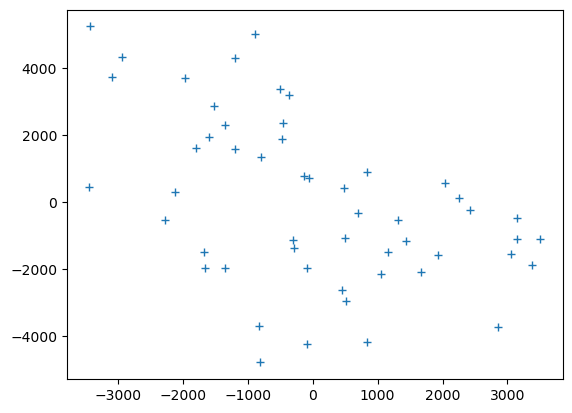

In [9]:
# plot pyranometer locations
tstart = int(10.5*3600)
tstop  = tstart+2*3600
tslice = slice(tstart,tstop)

plt.figure()
p = plt.plot(pyr.x.data,pyr.y.data,'+')

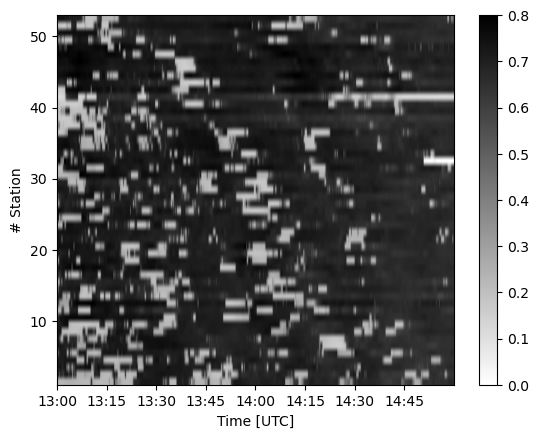

In [10]:
tstart = int(13.0*3600)
tstop  = tstart+2*3600
tslice = slice(tstart,tstop)

tlim = [
    mdates.date2num(pyr.time.data[tslice][0]),
    mdates.date2num(pyr.time.data[tslice][-1])
]

fig,ax = plt.subplots(1,1)

i_sy = np.argsort(-pyr.y.data)
im1 = ax.imshow(pyr.gtrans[tslice,i_sy].T, extent=[tlim[0],tlim[1], 1, 1+len(i_sy)], aspect="auto", cmap="gray_r", vmin=0.0, vmax=0.8)
_ = ax.set_ylabel("# Station")


date_fmt = mdates.DateFormatter('%H:%M')
xticks = ax.get_xticks()
ax.xaxis_date()
ax.xaxis.set_major_formatter(date_fmt)
_ = ax.set_xlabel("Time [UTC]")
fig.colorbar(im1, ax=ax)
fig.show()

## Read Calibration Files
Calibration factors are collected in share/pyrnet_calibration.json. The following function looks up the nearest calibration in time and fill missing values with earlier calibrations

In [11]:
# pyrnet_calibration.json structure
calib = {
    "2017-04":{
        "001":[7.1,7.2],
        "002":[7.51,7.61],
        "003":[6.9,6.91]
    },
    "2019-04": {
        "001":[7,None],
        "002":[7.5,7.6]
    }
}

date1 = np.datetime64("2019-03-01") # closer to "2019-04" calibration
date2 = np.datetime64("2018-01-01") # closer to "2017-04" calibration

# parse calibration dates
cdates = pd.to_datetime(list(calib.keys())).values

# sort calib keys beginning with nearest
skeys1 = np.array(list(calib.keys()))[np.argsort(np.abs(date1 - cdates))]
skeys2 = np.array(list(calib.keys()))[np.argsort(np.abs(date2 - cdates))]
print("Order of calibration lookup")
print(date1, '->' ,skeys1)
print(date2, '->' ,skeys2)

Order of calibration lookup
2019-03-01 -> ['2019-04' '2017-04']
2018-01-01 -> ['2017-04' '2019-04']


Lookup calibration, update with the most recent calibration but fill with earlier calibration if necessary.

In [12]:
# example for date1
for i, key in enumerate(skeys1[::-1]):
    if i==0:
        c = calib[key].copy()
        continue

    isNone = lambda x: np.any([xi is None for xi in x])
    isNotNone = lambda x: np.all([xi is not None for xi in x])
    # update with newer calibrations which not include None values
    c.update(valfilter(isNotNone, calib[key]))

    # update only not None values
    for k,v in valfilter(isNone, calib[key]).items():
        newv = [c[k][i] if vi is None else vi for i,vi in enumerate(v)]
        c.update({k:newv})
c

{'001': [7, 7.2], '002': [7.5, 7.6], '003': [6.9, 6.91]}

In [13]:
# example for date2
for i, key in enumerate(skeys2[::-1]):
    if i==0:
        c = calib[key].copy()
        continue

    isNone = lambda x: np.any([xi is None for xi in x])
    isNotNone = lambda x: np.all([xi is not None for xi in x])
    # update with newer calibrations which not include None values
    c.update(valfilter(isNotNone, calib[key]))

    # update only not None values
    for k,v in valfilter(isNone, calib[key]).items():
        newv = [c[k][i] if vi is None else vi for i,vi in enumerate(v)]
        c.update({k:newv})
c

{'001': [7.1, 7.2], '002': [7.51, 7.61], '003': [6.9, 6.91]}

In [14]:
calib

{'2017-04': {'001': [7.1, 7.2], '002': [7.51, 7.61], '003': [6.9, 6.91]},
 '2019-04': {'001': [7, None], '002': [7.5, 7.6]}}

In [15]:
#|export
def read_calibration(cfile:str, cdate):
    """
    Parse calibration json file

    Parameters
    ----------
    cfile: str
        Path of the calibration.json
    cdate: list, ndarray, or scalar of type float, datetime or datetime64
        A representation of time. If float, interpreted as Julian date.
    Returns
    -------
    dict
        Calibration dictionary sorted by box number.
    """
    cdate = utils.to_datetime64(cdate)
    calib = utils.read_json(cfile)
    # parse calibration dates
    cdates = pd.to_datetime(list(calib.keys())).values
    # sort calib keys beginning with nearest
    skeys = np.array(list(calib.keys()))[np.argsort(np.abs(cdate - cdates))]
    # lookup calibration factors
    for i, key in enumerate(skeys[::-1]):
        if i==0:
            c = calib[key].copy()
            continue
        isNone = lambda x: np.any([xi is None for xi in x])
        isNotNone = lambda x: np.all([xi is not None for xi in x])
        # update with newer calibrations which not include None values
        c.update(valfilter(isNotNone, calib[key]))
        # update only not None values
        for k,v in valfilter(isNone, calib[key]).items():
            newv = [c[k][i] if vi is None else vi for i,vi in enumerate(v)]
            c.update({k:newv})
    return c

Example using the package default pyrnet_calibration.json:

In [16]:
#|dropout
fn = pkg_res.resource_filename("pyrnet", "share/pyrnet_calibration.json")
read_calibration(fn,cdate=np.datetime64("2018-09-10"))

{'001': [7.73, 6.98],
 '002': [7.41, None],
 '003': [7.51, None],
 '004': [7.62, 8.23],
 '005': [7.48, 6.37],
 '006': [6.71, None],
 '007': [7.52, 7.2],
 '008': [7.58, None],
 '009': [7.59, 6.85],
 '010': [7.6, 6.74],
 '011': [7.32, None],
 '012': [7.6, 6.87],
 '013': [7.16, None],
 '014': [7.71, 7.3],
 '015': [7.59, 6.77],
 '016': [7.62, None],
 '017': [7.28, None],
 '018': [7.57, 6.9],
 '019': [7.57, None],
 '020': [7.32, None],
 '021': [7.4, None],
 '022': [7.43, None],
 '023': [7.46, None],
 '024': [7.73, 6.59],
 '025': [7.46, 7.14],
 '026': [7.64, 7.05],
 '027': [None, None],
 '028': [7.21, None],
 '029': [7.61, None],
 '030': [7.3, None],
 '031': [7.23, None],
 '032': [7.7, 6.94],
 '033': [7.74, 6.89],
 '034': [6.8, None],
 '035': [7.62, 7.1],
 '036': [None, None],
 '037': [7.72, 6.73],
 '038': [7.62, 6.93],
 '039': [7.27, None],
 '040': [7.15, None],
 '041': [7.38, None],
 '042': [7.15, None],
 '043': [7.41, 7.2],
 '044': [7.26, 7.05],
 '045': [7.52, None],
 '046': [7.7, 7.13],


## Read Box Serial numbers
Similar to reading the calibration, pyranometers attached to each box are stored in .json format. Reassigning of pyranometers to certain boxes might happen. Different to the calibration we will look up the most recent entry (not in the future)

In [17]:
# pyrnet_calibration.json structure
pyrnetmap = {
    "2019-04": {
        "001":["S11",None],
        "002":["S21","S33"]
    },
    "2017-04":{
        "001":["S11","S21"],
        "002":["S21","S22"],
        "003":["S31",None]
    },
}

date1 = np.datetime64("2019-03-01") # before "2019-04"
date2 = np.datetime64("2019-05-01") # after "2019-04"

# parse key dates
# require sort for lookup later
cdates = pd.to_datetime(list(pyrnetmap.keys())).values
isort = np.argsort(cdates)

# lookup most recent key
skeys1 = np.array(list(pyrnetmap.keys()))[isort][np.sum(date1>cdates)-1]
skeys2 = np.array(list(pyrnetmap.keys()))[isort][np.sum(date2>cdates)-1]
print("Order of calibration lookup")
print(date1, '->' ,skeys1)
print(date2, '->' ,skeys2)

Order of calibration lookup
2019-03-01 -> 2017-04
2019-05-01 -> 2019-04


Now we only have to look it up, no merging needed

In [18]:
#|export
def get_pyrnet_mapping(fn:str, date):
    """
    Parse box - serial number mapping  json file

    Parameters
    ----------
    fn: str
        Path of the mapping.json
    date: list, ndarray, or scalar of type float, datetime or datetime64
        A representation of time. If float, interpreted as Julian date.
    Returns
    -------
    dict
        Calibration dictionary sorted by box number.
    """
    date = utils.to_datetime64(date)
    pyrnetmap = utils.read_json(fn)
    # parse key dates
    # require sort for lookup later
    cdates = pd.to_datetime(list(pyrnetmap.keys())).values
    isort = np.argsort(cdates)

    # lookup most recent key
    skey = np.array(list(pyrnetmap.keys()))[isort][np.sum(date>cdates)-1]

    return pyrnetmap[skey]

## Lookup Serial, Boxnumber, calibration at certain date
Utility to lookup  box metadata for a certain date.


In [19]:
#|export
def meta_lookup(date,*,serial=None,box=None,cfile=None, mapfile=None):
    if cfile is None:
        cfile = pkg_res.resource_filename("pyrnet", "share/pyrnet_calibration.json")
    if mapfile is None:
        mapfile = pkg_res.resource_filename("pyrnet", "share/pyrnet_station_map.json")

    map = get_pyrnet_mapping(mapfile,date)
    calib = read_calibration(cfile,date)

    if serial is None and box is not None:
        box=int(box)
        return f"{box:03d}", map[f"{box:03d}"], calib[f"{box:03d}"]
    elif serial is not None and box is None:
        res = valfilter(lambda x: serial in x, map)
        box = list(res.keys())[0]
        serial = res[box]
        return box,serial,calib[box]
    else:
        raise ValueError("At least one of [station,box] have to be specified.")

In [20]:
date = np.datetime64("2018-10-01")
print(meta_lookup(date,serial="S12078.061"))
print(meta_lookup(date,box=10))

('006', ['S12078.061', ''], [6.71, None])
('010', ['S12128.010', 'S12137.019'], [7.6, 6.74])


In [21]:
#|hide
import nbdev.export
import nbformat as nbf
name = "pyrnet"

# Export python module
nbdev.export.nb_export( f"{name}.ipynb" ,f"../../src/pyrnet")

# Export to docs
ntbk = nbf.read(f"{name}.ipynb", nbf.NO_CONVERT)

text_search_dict = {
    "#|hide": "remove-cell",  # Remove the whole cell
    "#|dropcode": "hide-input",  # Hide the input w/ a button to show
    "#|dropout": "hide-output"  # Hide the output w/ a button to show
}
for cell in ntbk.cells:
    cell_tags = cell.get('metadata', {}).get('tags', [])
    for key, val in text_search_dict.items():
            if key in cell['source']:
                if val not in cell_tags:
                    cell_tags.append(val)
    if len(cell_tags) > 0:
        cell['metadata']['tags'] = cell_tags
    nbf.write(ntbk, f"../../docs/source/nbs/{name}.ipynb")

/home/jonas/miniconda3/envs/pyrnet/lib/python3.11/site-packages/nbformat/__init__.py:92: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)
